# Этап 1. Получение данных и их подготовка к анализу

Получим данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Прочитаем данные из файлов и выведем их на экран.

In [1]:
# Загрузим данные о визитах, заказах и расходах.
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statistics
from numpy import median

visits = pd.read_csv('/data/visits_log.csv')
orders = pd.read_csv('/data/orders_log.csv')
costs = pd.read_csv('/data/costs.csv')

C:\Users\valen\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Приведем названия столбцов к нижнему регистру, а также вставим нижнее подчеркивание. Так увеличивается читаемость.

In [2]:
for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')

Напишем функцию, которая выводит пример записей и тип данных таблицы.

In [3]:
# уберем перенос строки
pd.options.display.expand_frame_repr = False

def df(df):
    print('Данные таблицы:\n%s\n\n'
          'Типы строк таблицы:\n%s\n' % (df.sample(3), df.dtypes))

In [4]:
df(visits)

Данные таблицы:
         device               end_ts  source_id             start_ts                   uid
132621    touch  2018-01-20 14:57:00         10  2018-01-20 14:55:00  14865789969496115129
338353  desktop  2017-12-25 11:50:00          4  2017-12-25 11:35:00  14899801043168018167
101215  desktop  2018-02-07 13:02:00          5  2018-02-07 13:01:00  10796281761078737787

Типы строк таблицы:
device       object
end_ts       object
source_id     int64
start_ts     object
uid          uint64
dtype: object



In [5]:
df(orders)

Данные таблицы:
                    buy_ts  revenue                   uid
3788   2017-07-17 23:55:00     6.42   6195533483103326319
3851   2017-07-18 14:34:00     6.72  17656224880650706954
43833  2018-04-11 22:52:00     4.43  16088597493154724671

Типы строк таблицы:
buy_ts      object
revenue    float64
uid         uint64
dtype: object



In [6]:
df(costs)

Данные таблицы:
      source_id          dt   costs
1507          5  2017-07-26   71.70
894           3  2017-11-16  749.26
1396          4  2018-04-06  118.28

Типы строк таблицы:
source_id      int64
dt            object
costs        float64
dtype: object



Все даты в таблицах имеют неверный тип данных. Поэтому найдем все столбцы с типом данных объект (кроме названия устройства) и заменим на формат даты.

In [7]:
for df in [visits, orders, costs]:
    cols = df.select_dtypes(include = ['object']).columns.difference(['device'])
    for col in cols:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M')

В итоге получили данные по поведению пользователей Яндекс.Афишы, их заказы и маркетинговые расходы. Все данные таблиц приведены к нужному типу.

# Этап 2. Юнит-экономика

Добавим столбцы с днем, неделей, месяцем, а также длительностью сессии в секундах.

In [8]:
visits['day'] = visits['start_ts'].dt.day
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

## Продуктовые показатели

Ответим на вопросы:
* Сколько людей пользуются в день, неделю, месяц?
* Сколько сессий в день?
* Сколько длится одна сессия?
* Как часто люди возвращаются?

In [9]:
def hist(data, column1, column2, func, title): # тепловая карта
    visit_count = data.groupby([column1, 'device']).agg({column2:func}).reset_index()
    visit_count.columns = [column1, 'device', 'count']
    fig, ax = plt.subplots(figsize=(16,7))
    g = sns.barplot(x=column1, 
                    y = 'count', 
                    hue='device',
                    data = visit_count).set_title(title, fontsize=16) 
    sns.despine()
    plt.show()

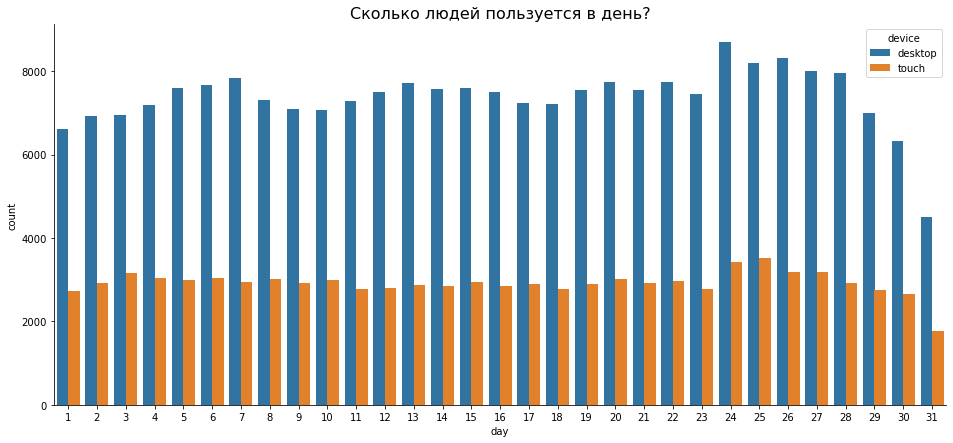

In [10]:
hist(visits, 'day', 'uid', 'nunique', 'Сколько людей пользуется в день?')

Чаще всего пользуются desktop'ом. Пик посещаемости приходится на 24 число месяца (наверно, перед получением заработной платы?)

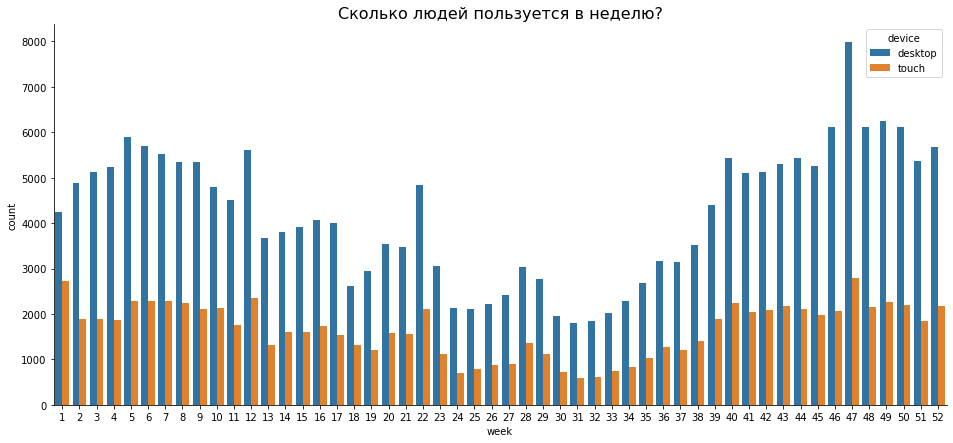

In [11]:
hist(visits, 'week', 'uid', 'nunique', 'Сколько людей пользуется в неделю?')

Пик посещаемости приходится на 47 неделю.

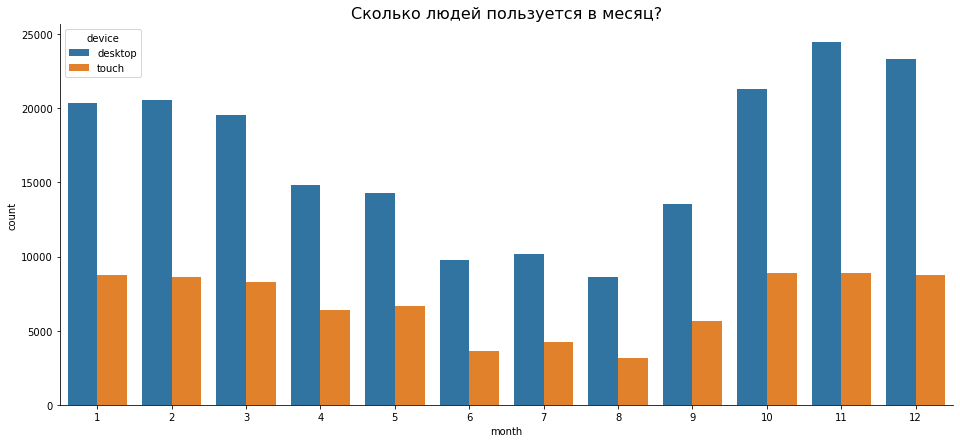

In [12]:
hist(visits, 'month', 'uid', 'nunique', 'Сколько людей пользуется в месяц?')

В начале и конце года активность зашкаливает.

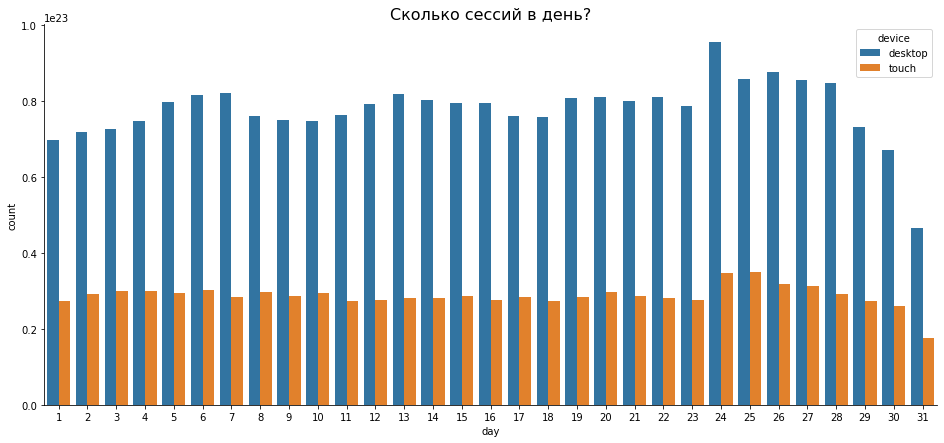

In [13]:
hist(visits, 'day', 'uid', 'sum', 'Сколько сессий в день?')

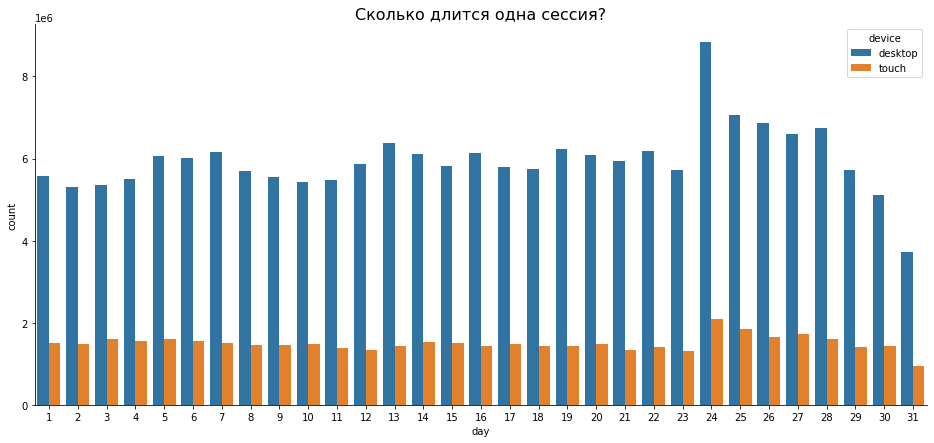

In [14]:
hist(visits, 'day', 'session_duration_sec', 'sum', 'Сколько длится одна сессия?')

Cредняя продолжительность сессии равна 60 секунд.


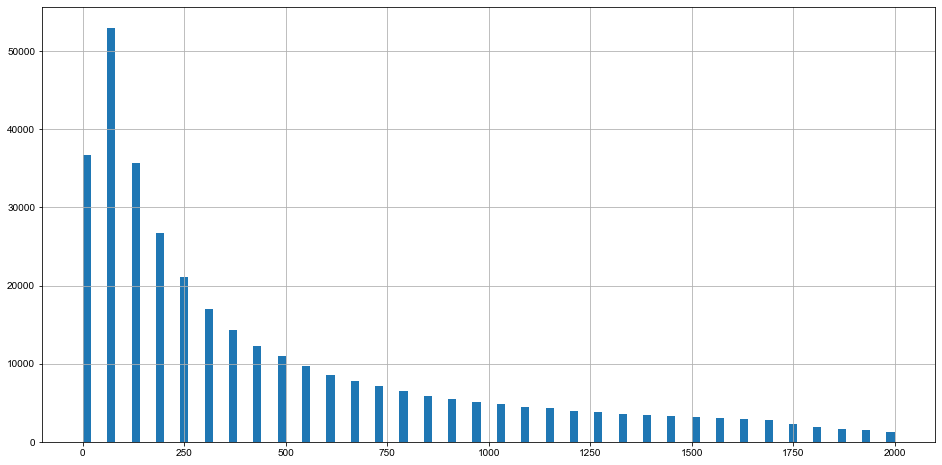

In [15]:
plt.figure(figsize=(16,8))
visits['session_duration_sec'].hist(bins=100,  
                                    range = (0,2000))
sns.set()

print('Cредняя продолжительность сессии равна {} секунд.'.format(statistics.mode(visits['session_duration_sec'])))

Посмотрим, как часто люди возвращаются. Для этого нужно посмотреть показатель удержания клиентов.
Датасет visits содержит информацию об активности пользователей на сайте. Определим событие и период — на их основе сформируем когорту. Возьмём дату и месяц, когда пользователь впервые проявил активность.

In [16]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
first_date = visits.groupby(['uid'])['start_ts'].min()
first_date.name = 'first_visit_date'
visits = visits.join(first_date, on='uid')

visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')

visits.head(3)

,device,end_ts,source_id,start_ts,uid,day,week,month,session_duration_sec,first_visit_date,visit_month,first_visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,20,51,12,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,19,8,2,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,1,26,7,0,2017-07-01 01:54:00,2017-07-01,2017-07-01


Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты. 

In [17]:
visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Сгруппируем данные по когорте и cohort_lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:

In [18]:
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц.

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц:

In [19]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count

,first_visit_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Переименуем столбец Uid в cohort_users методом rename(). Параметру columns передадим словарь, где ключ — старое название столбца, а значение — новое:

In [20]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

Объединим данные по когортам с исходным количеством пользователей в когорте:

In [21]:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

Наконец, рассчитаем Retention Rate. Разделим количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте:

In [22]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

Построим сводную таблицу и создадим тепловую карту (напишем отдульну функцию на график, так как его будет использовать ни один раз):

In [23]:
def heatmap(df, title, fmt, vmin, vmax):
    plt.figure(figsize=(13,9))
    plt.title(title, fontsize=16)
    sns.heatmap(df,
                annot=True, 
                fmt=fmt, 
                linewidths=1, 
                linecolor='gray', 
                vmin=vmin, 
                vmax=vmax);

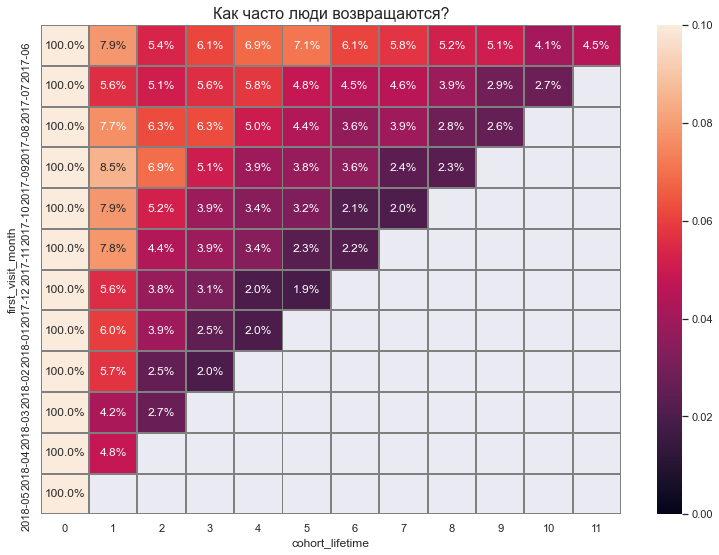

In [24]:
retention_pivot = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')

heatmap(retention_pivot, 'Как часто люди возвращаются?', '.1%', 0, 0.1)

Показатель удержания в первую неделю выше всего был в сентябре и последущие два месяца, а так же в январе.

## Показатели продажи

Ответим на вопросы:
* Когда люди начинают покупать?
* Сколько раз покупают за период?
* Какой средний чек?
* Сколько денег приносят? (LTV)

Для того, чтобы понять, когда люди начинают покупать, найдем разницу между датой начала сессии и датой первой покупки (delta_mins) в минутах. А ещё можно посмотреть распределение результатов по персентелям.

In [25]:
data1 = (visits.groupby(['uid', 'device'])
               .agg({'start_ts':'min'})
               .join(orders.groupby('uid')
               .agg({'buy_ts':'min','revenue':'sum'}), how = 'right')).reset_index()
         
data1['delta_mins'] = (data1['buy_ts'] - data1['start_ts']).dt.total_seconds()/60

(data1.groupby('device')['delta_mins']
      .describe(percentiles= [0.10, 0.15, 0.25, 0.50, 0.75, 0.80, 0.95])).reset_index()

,device,count,mean,std,min,10%,15%,25%,50%,75%,80%,95%,max
0,desktop,30602.0,21393.220705,67998.301982,-460071.0,1.0,1.0,3.0,14.0,1561.5,7066.6,170923.65,523144.0
1,touch,8912.0,13579.694906,89196.931830,-510583.0,-6115.7,0.0,2.0,18.0,5769.5,16542.2,186797.10,522287.0


Посмотрим, сколько раз покупают за период. Нарисуем график распределения покупок по устройствам и найдем медианное значение.

,device,mean_value
0,desktop,2609.0
1,touch,762.5


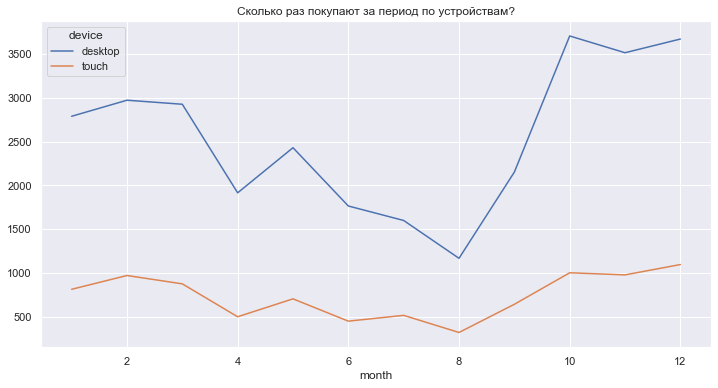

In [26]:
data1['month'] = data1['buy_ts'].dt.month

df = data1.pivot_table(index = 'month', 
                       columns = 'device',  
                       values='uid', 
                       aggfunc='count')

df.plot(figsize=(12, 6),
        title = 'Сколько раз покупают за период по устройствам?');
sns.set()
df.median().reset_index().rename(columns = {0:'mean_value'})

Чаще всего покупки совершают с устройства desktop: примерно 2600 раз за месяц.

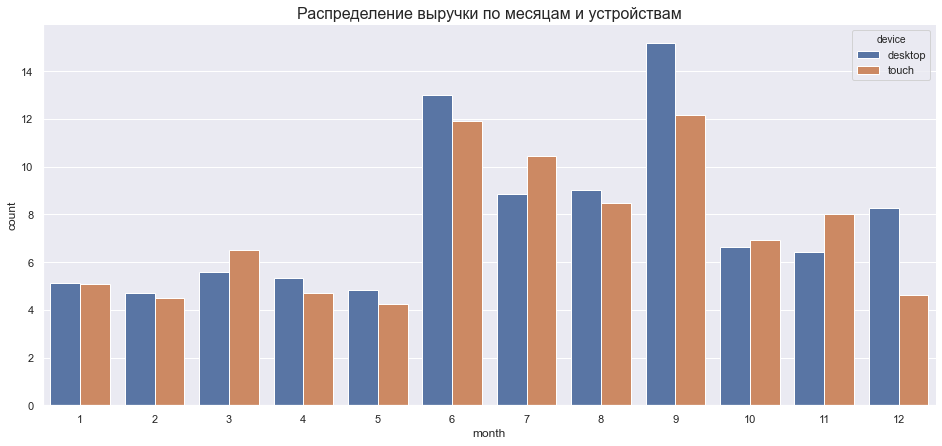

In [27]:
hist(data1, 'month', 'revenue', 'mean', 'Распределение выручки по месяцам и устройствам')

А вот если смотреть распределение выручки по устройствам, то лидирует desktop, но с небольшим отрывом. Больше всего выручки Афиша получает с июне и сентябре (начало летних каникул и начало учебного года). А вот в начале и конце года выручка стабильна.

Посмотрим средний чек покупателей.
Есть данные о каждом покупателе: дата и стоимость его заказа. Зная даты заказов, можно получить и самую раннюю. Затем, сгруппировав пользователей по дате первой покупки, сформировать когорты.

In [28]:
orders['order_date'] = pd.to_datetime(orders['buy_ts'])

first_orders = orders.groupby('uid')['order_date'].min() 
first_orders.name = 'first_order_date'

orders = orders.join(first_orders,on='uid')

Выделим месяц первого заказа. Вызовем метод astype(): преобразуем значения столбцов к типу 'datetime64[M]'. [M] в типе datetime64 означает размерность временной метки, в этом случае — месяц:

In [29]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['order_date'].astype('datetime64[M]')

Когортой станет столбец first_order_month — месяц, в котором был сделан первый заказ. Сгруппируем данные по этому столбцу и оценим показатели каждой когорты. Применим знакомый метод agg. Ему передают словарь, где ключи — названия столбцов, а значения — агрегирующие функции.

In [30]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})

Найдём средний чек покупателя revenue_per_user — разделим показатель revenue на Uid:

In [31]:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']

Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, как изменяется средний чек с течением времени:

In [32]:
orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                      columns='order_month',
                                      values='revenue_per_user',
                                      aggfunc='mean').reset_index()
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()

Нужно оценить, как изменяется средний чек в зависимости от времени, прошедшего с момента первой покупки Для когорты покупателей такой показатель называют cohort_lifetime. Эта метрика для каждого события отображает, в каком по счёту месяце от месяца когорты оно произошло. 

Рассмотрим cohort_lifetime для когорты покупателей, которые совершили первую покупку в июне 2018:
- покупки, сделанные в этом же месяце, будут считаться выполненными на нулевом месяце lifetime;
- покупки, выполненные в июле 2018 — уже на первом месяце cohort_lifetime.

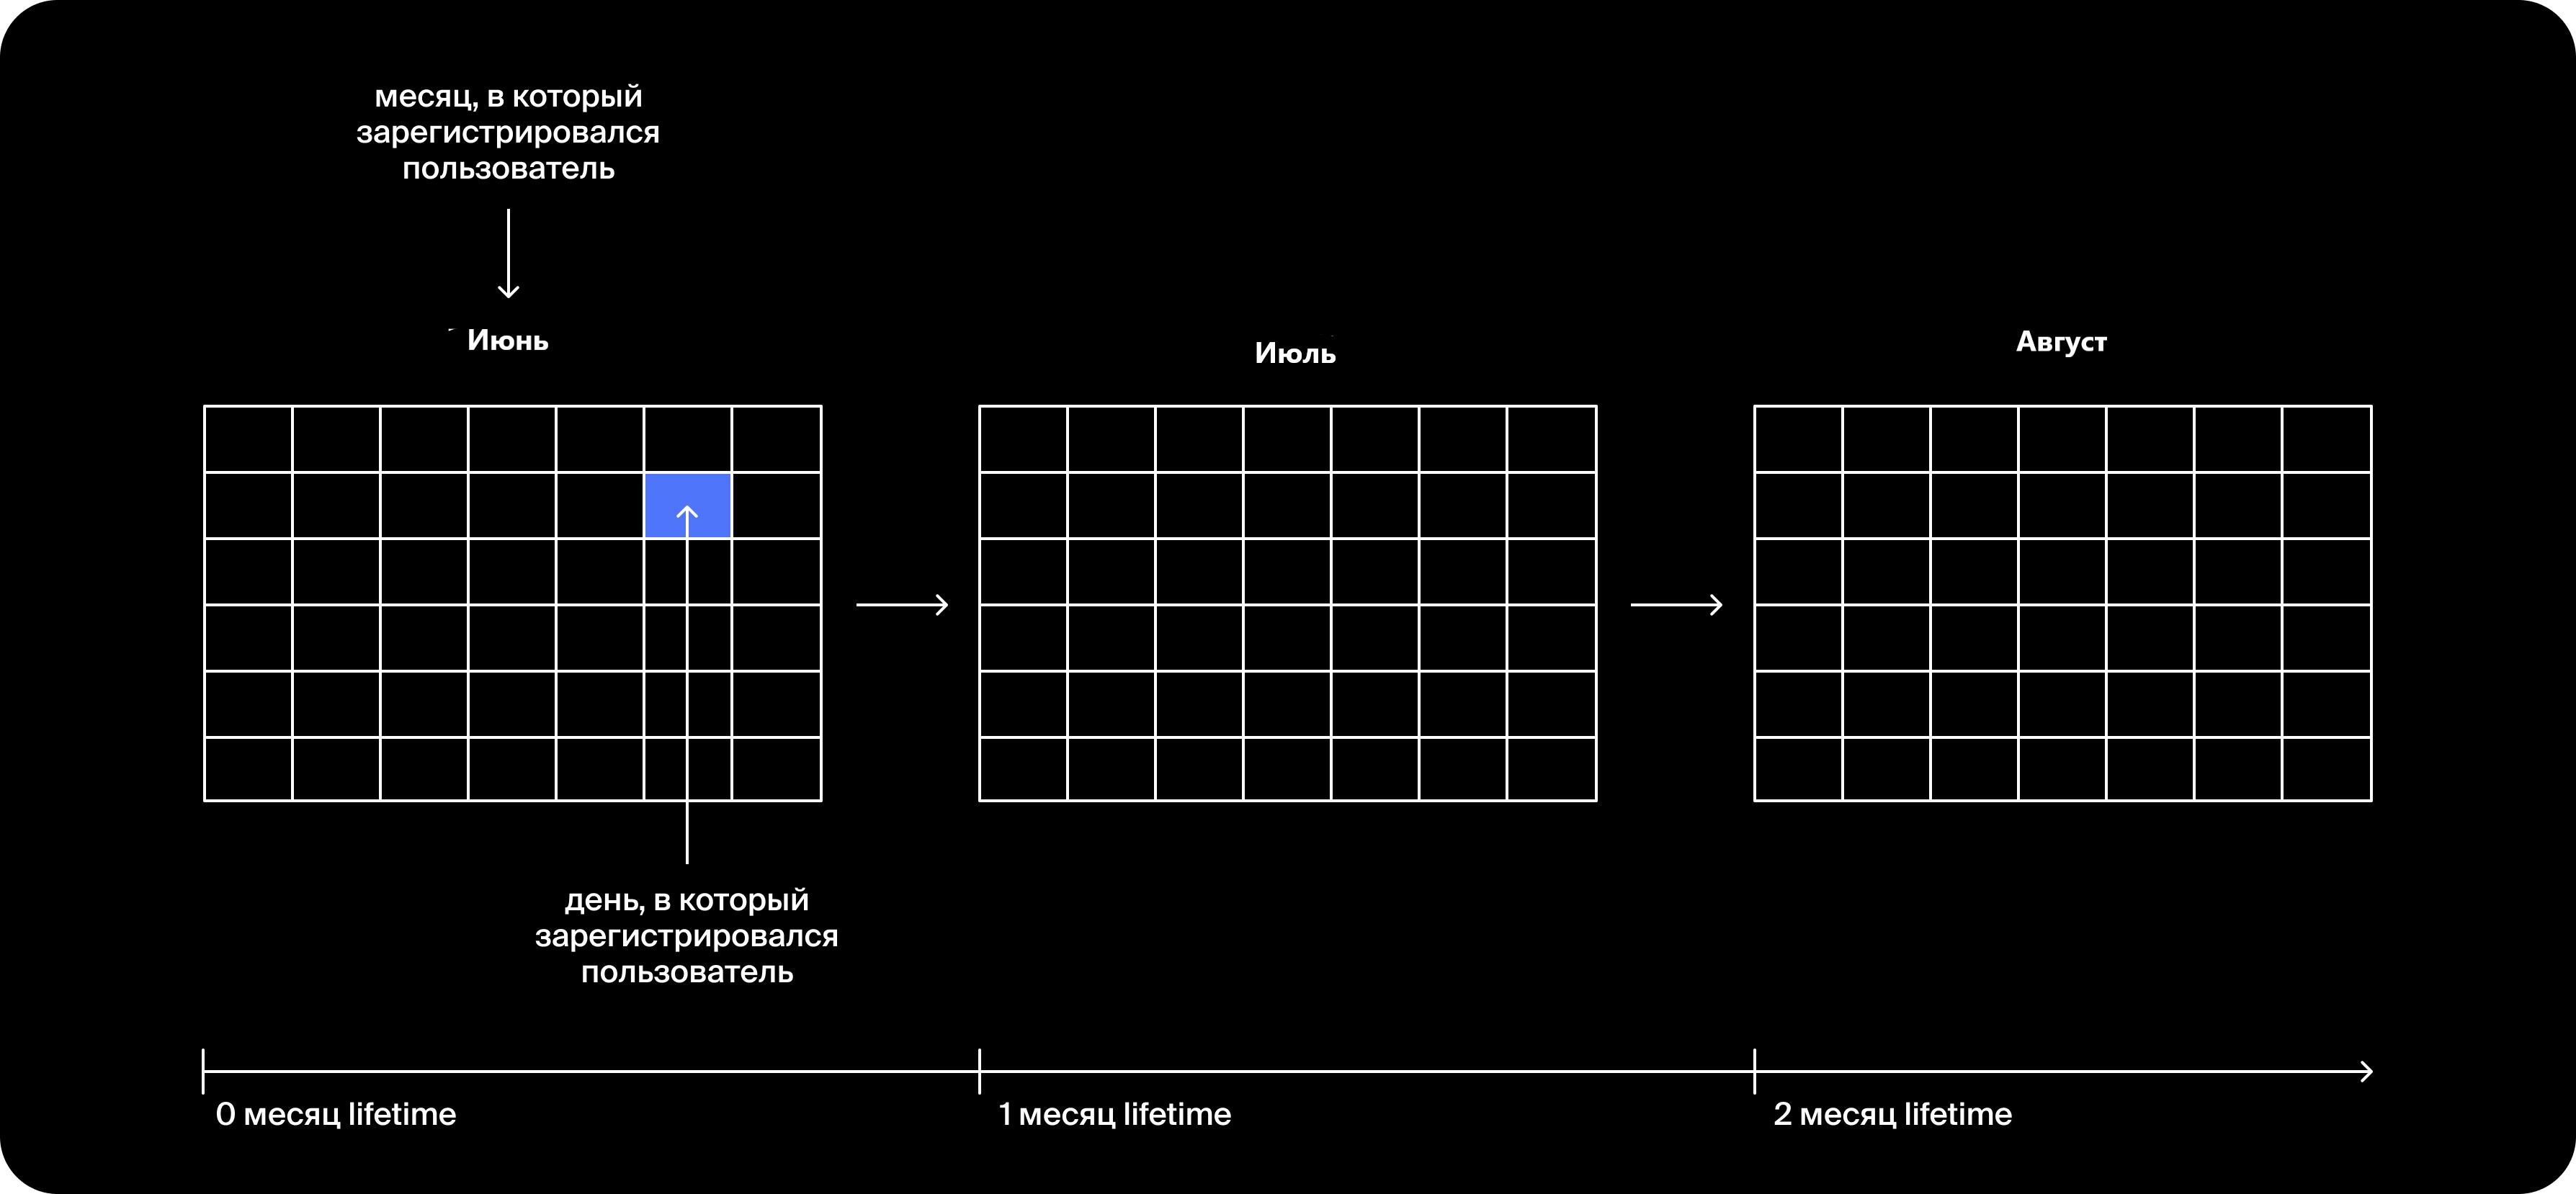

Найдем "возраст" когорты, чтобы посмотреть показатели нарастающим итогом

In [33]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] \
                                             - orders_grouped_by_cohorts['first_order_month']

Получили столбец cohort_lifetime с типом timedelta. Он хранит в себе разницу между двумя датами. Преобразуем этот тип в число месяцев, прошедших между датами. Для этого cohort_lifetime нужно разделить на константу np.timedelta64(1, 'M') — узнать, сколько величин длиной в 1 месяц содержится в cohort_lifetime.

In [34]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')

Получили дробные числа. Это связано с тем, что константа np.timedelta64(1,'M') представляет собой среднюю длину месяца в году. В месяце бывает от 28 дней до 31, вот и числа вышли не целые. Округлим значения столбца cohort_lifetime методом round(), а затем приведём их к целочисленному типу методом astype('int'):

In [35]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

Получили целое число месяцев, обозначающее порядковый месяц совершения покупки относительно месяца первой покупки.
Когда все расчёты выполнены, оставим в обозначении когорты только год и месяц. Применим метод dt.strftime() — он превращает объект Series с типом datetime в строку в формате даты.

In [36]:
orders_grouped_by_cohorts['first_order_month'].dt.strftime('%d.%m.%Y')

0     01.06.2017
1     01.06.2017
2     01.06.2017
3     01.06.2017
4     01.06.2017
         ...    
74    01.03.2018
75    01.04.2018
76    01.04.2018
77    01.05.2018
78    01.06.2018
Name: first_order_month, Length: 79, dtype: object

Оставим в данных о месяце первого заказа только год и месяц:

In [37]:
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

Построим сводную таблицу изменения среднего чека, где в столбцах будет cohort_lifetime, а строках — когорты:

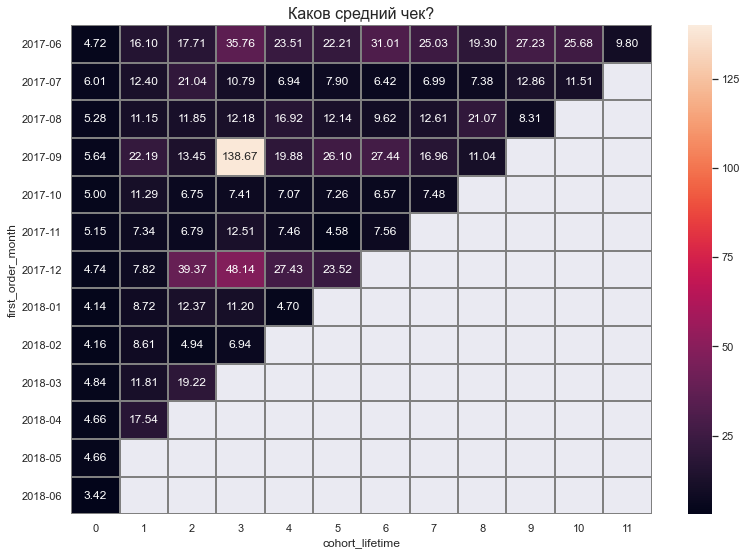

In [38]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                               columns='cohort_lifetime',
                                                               values='revenue_per_user',
                                                               aggfunc='mean')

heatmap(revenue_per_user_pivot, 'Каков средний чек?', '.2f', 3, 140)

Если смотреть, как распределен средний чек по времени, то можно заметить, что в сентябре значение выше всего (на 4-ую неделю). Те, кто зарегистрировались в декабре, имеют на 3-4 неделю увеличивают размер прибыли для "Афишы".

Считаем экономику одного покупателя. Для этого посмотрим количество новых покупателей за каждый месяц.

In [39]:
cohort_sizes = orders[['uid','first_order_month']].groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами:

In [40]:
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].astype('datetime64[M]')
orders_grouped_by_cohorts = pd.merge(cohort_sizes, orders_grouped_by_cohorts, on='first_order_month')

LTV считают не из выручки, а из валовой прибыли. Значит, нужно найти валовую прибыль, умножив выручку на маржинальность.

Найдём LTV: разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде сводной таблицы ltv_pivot:

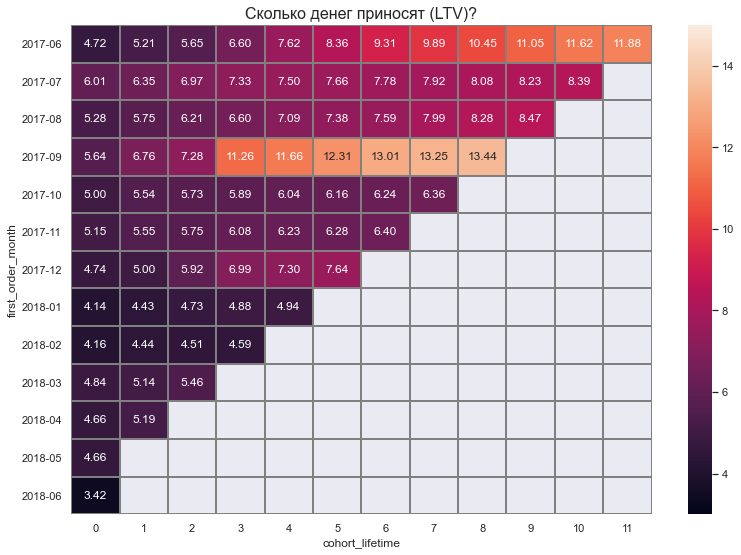

In [41]:
# Маржинальность обычно не известна, поэтому примем размер маржи в единицу.
margin_rate = 1.0
orders_grouped_by_cohorts['gp'] =  orders_grouped_by_cohorts['revenue'] * margin_rate
orders_grouped_by_cohorts['ltv'] = orders_grouped_by_cohorts['gp'] / orders_grouped_by_cohorts['n_buyers']
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

ltv_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                  columns='cohort_lifetime',
                                                  values='ltv',
                                                  aggfunc='sum')

heatmap(ltv_pivot.cumsum(axis=1).round(2), 'Сколько денег приносят (LTV)?', '.2f', 3, 15)

Около 50% всех значений времени покупки - меньше 16 минут, поэтому можно сказать, что более половины пользователей совершают быстрые покупки. 90% всех значений разницы между временем регистрации и временем совершения покупки меньше 123 дней, 75% всех значений - меньше 2 дней. 10% пользователей делат покупку в первую минуту прибывания на сайте.
       
Чтобы посмотреть, сколько денег приносят покупки, надо посмотреть на показатель LTV. Максимум прибыли в сентябрьской когорте.

## Маркетинговые показатели

Ответим на вопросы:
* Сколько денег потратили: всего, по источникам, по времени?
* Сколько стоило привлечение одного покупателя из каждого источника?
* На сколько окупились расходы (ROI)?

Чтобы посмотреть распределение затрат по источникам, выделим в датасете месяц и сгруппируем по нему данные.

In [42]:
costs['month'] = costs['dt'].dt.month
costs1 = costs.pivot_table(index = 'month', columns = 'source_id', values = 'costs', aggfunc = 'sum').reset_index()

Посмотрим распределение затрат с течением месяцев по источникам на графике.

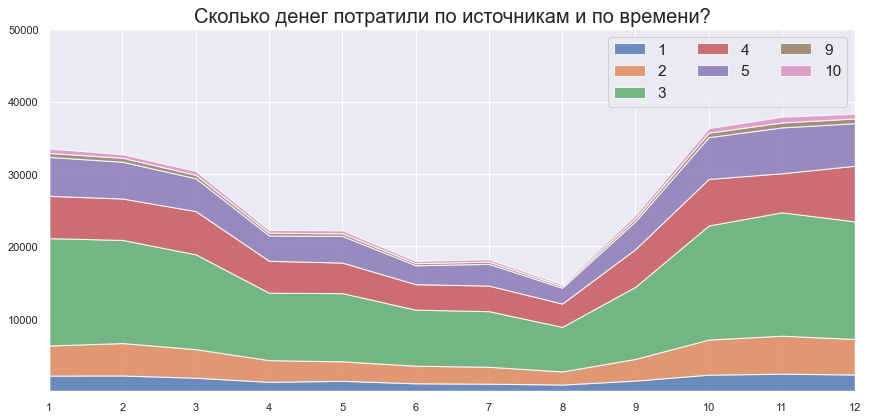

In [43]:
fig, ax = plt.subplots(1,1,figsize=(13, 6), dpi= 80)
columns = costs1.columns[1:]
labs = columns.values.tolist()

x  = costs1['month'].values.tolist()
y1 = costs1[1].values.tolist()
y2 = costs1[2].values.tolist()
y3 = costs1[3].values.tolist()
y4 = costs1[4].values.tolist()
y5 = costs1[5].values.tolist()
y9 = costs1[9].values.tolist()
y10 = costs1[10].values.tolist()

y = np.vstack([y1, y2, y3, y4, y5, y9, y10])

ax = plt.gca()
ax.stackplot(x, y, labels=labs, alpha=0.8)

ax.set_title('Сколько денег потратили по источникам и по времени?', fontsize=18)
ax.set(ylim=[0, 12])
ax.legend(fontsize=14, ncol=3)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(10000, 60000, 10000), fontsize=10)
plt.xlim(x[0], x[-1])
sns.set()
plt.show()

In [44]:
costs.pivot_table(index = 'source_id', 
                   columns = 'month', 
                   values = 'costs', 
                   aggfunc = 'sum',
                   margins=True).style.format('{0:,.0f}').background_gradient()

month,1,2,3,4,5,6,7,8,9,10,11,12,All
source_id,,,,,,,,,,,,,
1,"2,186","2,204","1,893","1,327","1,468","1,126","1,073",952,"1,502","2,316","2,445","2,341","20,833"
2,"4,158","4,474","3,943","2,994","2,689","2,427","2,333","1,811","2,986","4,845","5,248","4,898","42,806"
3,"14,809","14,229","13,081","9,297","9,411","7,732","7,674","6,144","9,964","15,737","17,025","16,220","141,322"
4,"5,833","5,712","5,962","4,408","4,214","3,515","3,530","3,217","5,192","6,421","5,389","7,680","61,074"
5,"5,372","5,071","4,530","3,501","3,670","2,616","2,998","2,185","3,849","5,767","6,325","5,873","51,757"
9,547,552,480,373,362,285,303,249,416,609,683,658,"5,517"
10,614,481,526,388,410,314,330,233,461,627,792,646,"5,822"
All,"33,519","32,723","30,415","22,289","22,224","18,015","18,241","14,791","24,369","36,323","37,908","38,315","329,132"


Больше всего денег потратили в декабре (38 тыс.), а меньше всего - в августе (около 15 тыс.). Всего за анализируемый период потратили 329,13 тыс. Самые большие инвестиции у третьего источника (максимум по каждому месяцу), а самая маленькие - 9-10 источники. Сумма денег по истоничкам уменьшается с апрель по август включительно.

Вложения в привлечение покупателей окупились по каждому источнику, но больше всего по 9-10 источникам (они лидеры среди показателя ROMI).

Посмотрим, на сколько обошлось привлечение одного покупателя (показатель CAC). Для этого получим месячные расходы по когортам monthly_costs.

In [45]:
table = pd.merge(orders, visits, on='uid')
table = pd.merge(cohort_sizes, table, on='first_order_month')

table['gp'] =  table['revenue'] * margin_rate
table['ltv'] = table['gp'] / table['n_buyers']
table['age'] = ((table['order_month'] - table['first_order_month'])/ np.timedelta64(1,'M')).round().astype('int')

table = table.pivot_table(index = ['first_order_month','n_buyers','order_month','age','visit_month'],
                          values = ['revenue','gp','ltv'],
                          aggfunc = 'sum').reset_index()

costs['month'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby(['source_id','month']).sum().reset_index()

report_last = pd.merge(table, monthly_costs, left_on='first_order_month', right_on='month')

Посчитаем CAC когорты. Поделим расходы за месяц на количество людей в когорте:

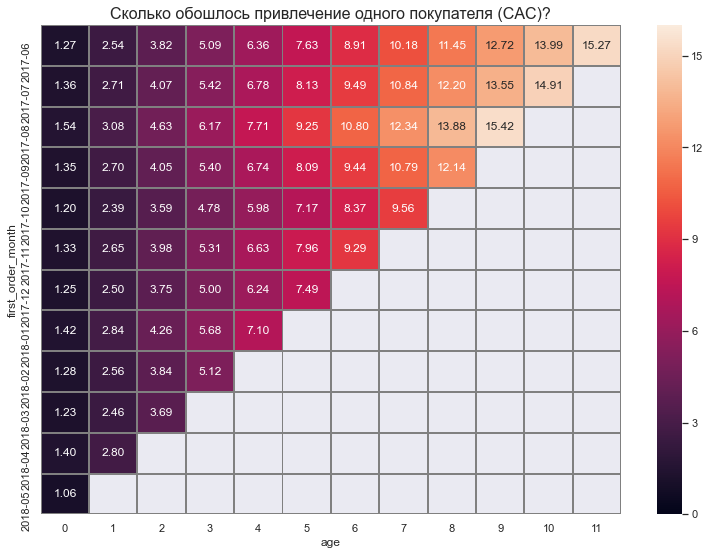

In [46]:
report_last['cac'] = report_last['costs'] / report_last['n_buyers']
report_last['first_order_month'] = report_last['first_order_month'].dt.strftime('%Y-%m')

output_cac = report_last.pivot_table(index='first_order_month', 
                                     columns='age',
                                     values='cac', 
                                     aggfunc='mean')  

heatmap(output_cac.cumsum(axis=1).round(2), 'Сколько обошлось привлечение одного покупателя (CAC)?', '.2f', 0, 16)

На сколько же окупились расходы? Посмотрим показатель ROMI.

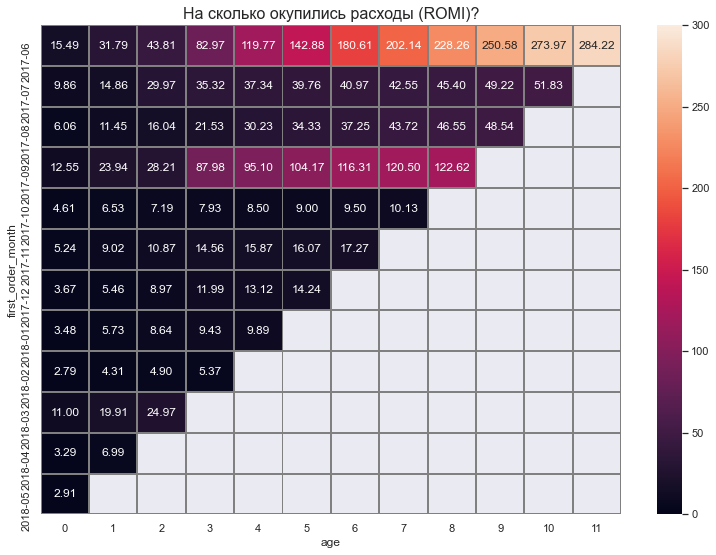

In [47]:
report_last['romi'] = report_last['ltv'] / report_last['cac']

output_romi = report_last.pivot_table(index='first_order_month', 
                                      columns='age',
                                      values='romi', 
                                      aggfunc='mean')  

heatmap(output_romi.cumsum(axis=1).round(2), 'На сколько окупились расходы (ROMI)?', '.2f', 0, 300)

In [48]:
print('Итоговая окупаемость по источникам равна:', report_last.groupby('source_id')['romi'].mean())

Итоговая окупаемость по источникам равна: source_id
1      5.569354
2      2.668730
3      0.818087
4      1.758712
5      2.290042
9     21.176568
10    19.576381
Name: romi, dtype: float64


# Этап 3. Общие итоги

Самое популярное устройство для посещения сайта - desktop, оно же лидирует по выручке, но не сильно отличается от touch, это значит, что оплату мероприятия на desktop можно усовершенствовать (какие-то ошибки \ затруднения при оплате у пользователей).
    
К концу месяца количество пользователей уменьшается (с 24 числа), по неделям максимальное количество пользователей в начале и в конце периода (особенно лидирует 47 неделя),то же самое можно сказать и про месяца (посещение зашкаливает в начале и конце анализированного периода).
    
Максимальное кол-во сессий в день приходится на 24-е число месяца. Наверно, это взязано с выплатами з\п, и пользователи начинают планировать свой досуг.

Средняя продолжительность сессии составляет одна минута. Следовательно, пользователей почти ничего не привлекает и не заинтересовывает на странице Афиша. Либо они целенаправленно посещают те страницы, мероприятия по которым им уже известны, либо не совершают никаких покупок и выходят.
        
Около 50% всех значений времени покупки - меньше 14 - 18 минут, поэтому можно сказать, что более половины пользователей совершают быстрые покупки. 90% всех значений разницы между временем регистрации и временем совершения покупки меньше 123 дней, 75% всех значений - меньше 2 дней. 10% пользователей делат покупку в первую минуту прибывания на сайте.
    
Retention Rate в первую неделю резко уменьшился (с 7.9% до 5.6%). Пик возврата приходится на неделю с 1 сентября (8.5%). Что логично в связи с началом учебного года. Далее идет на спад до декабря. С декабря по январь показатель повышается (Новый год же!), а потом опять уменьшается.
       
В сентябре значение среднего чека выше всего (на 4-ую неделю). Те, кто зарегистрировались в декабре, имеют на 3-4 неделю увеличивают размер прибыли для "Афишы".

Максимум прибыли в сентябрьской когорте.

Больше всего денег на маркетинг потратили в декабре (38 тыс.), а меньше всего - в августе (около 15 тыс.). Всего за анализируемый период потратили 329,13 тыс. Самые большие инвестиции у третьего источника (максимум по каждому месяцу), а самая маленькие - 9-10 источники. Сумма денег по истоничкам уменьшается с апрель по август включительно.

Вложения в привлечение покупателей окупились по каждому источнику, но больше всего по 9-10 источникам (они лидеры среди показателя ROMI).